# <center>Terry Stops Classifier

## Business Understanding
**Stakeholder**: Seattle Police Department (SPD)  
**Business Problem**: The SPD wants to identify which factors contribute to an arrest during Terry Stops to reduce unnecessary stops and enhance resource allocation.  
**Objective**: Build a classification model to predict whether a stop leads to an arrest.  
**Target Variable**: Arrest Flag (1 = Arrested, 0 = Not Arrested)  
**Value**: Insights can help SPD prioritize high-risk stops while reducing racial bias and inefficiency in policing.

# Data Understanding

In [1]:
#Import the necessary libraries/packages for EDA, modeling, and evaluation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.feature_selection import RFECV, RFE 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

In [2]:
#load dataset
df = pd.read_csv("Terry_Stops_20250719.csv")
df.head() #data preview

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,47:00.0,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,43:00.0,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,36:00.0,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,25:58.0,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,53:15.0,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2


In [3]:
#Exploratory data analysis
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  object 
 1   Subject ID                64186 non-null  int64  
 2   GO / SC Num               64186 non-null  float64
 3   Terry Stop ID             64186 non-null  int64  
 4   Stop Resolution           64186 non-null  object 
 5   Weapon Type               31621 non-null  object 
 6   Officer ID                64186 non-null  object 
 7   Officer YOB               64186 non-null  int64  
 8   Officer Gender            64186 non-null  object 
 9   Officer Race              64186 non-null  object 
 10  Subject Perceived Race    64186 non-null  object 
 11  Subject Perceived Gender  64186 non-null  object 
 12  Reported Date             64186 non-null  object 
 13  Reported Time             64186 non-null  object 
 14  Initia

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 563
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64

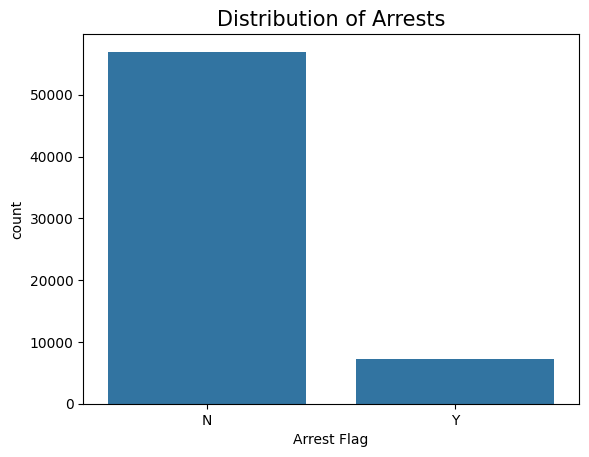

<Figure size 640x480 with 0 Axes>

In [4]:
#Target Distribution Visualization
sns.countplot(x='Arrest Flag', data=df)
plt.title('Distribution of Arrests', fontsize = 15)
plt.show()

#save plot
plt.savefig('arrests_distribution.png', dpi=300)

- There appears to be a massive class imbalance in the target variable. 
- Must keep this in mind for modeling stages and adjust accordingly.
- The trained model might end up predicting non-arrests better than arrests.

In [5]:
df['Subject Perceived Gender'].value_counts()
df['Subject Perceived Race'].value_counts()


Subject Perceived Race
White                                        31415
Black or African American                    19316
Unknown                                       4861
Asian                                         2209
-                                             1822
American Indian or Alaska Native              1738
Hispanic                                      1684
Multi-Racial                                   809
Native Hawaiian or Other Pacific Islander      179
Other                                          152
MULTIPLE SUBJECTS                                1
Name: count, dtype: int64

In [6]:
# Abbreviations for race and gender
race_abbrev = {
    'White': 'W', 
    'Black or African American': 'B', 
    'Asian': 'A', 
    'Hispanic': 'H', 
    'American Indian or Alaska Native': 'AI', 
    'Native Hawaiian or Other Pacific Islander': 'PI',
    'Unknown': 'U',
    'Multiple Subjects': 'MS',
    'Multi-Racial': 'MR',
    'Declined to Answer': 'DTA',
    'Two or More Races': '2/More' 
 
}

gender_abbrev = {
    'Male': 'M',
    'Female': 'F',
    'Transgender Male': 'TM',
    'Transgender Female': 'TF',
    'Gender Diverse (gender non-conforming and/or transgender)': 'GNC',
    'Unknown': 'U',
    'MULTIPLE SUBJECTS': 'MS',
    'Unable to Determine': 'UTD',
    'Non-Specified': 'NS'

}


In [7]:
#Replacing values with abbreviations
df_plot = df.copy()
df_plot['Subject Race Abbrev'] = df_plot['Subject Perceived Race'].replace(race_abbrev)
df_plot['Officer Race Abbrev'] = df_plot['Officer Race'].replace(race_abbrev)
df_plot['Subject Gender Abbrev'] = df_plot['Subject Perceived Gender'].replace(gender_abbrev)
df_plot['Officer Gender Abbrev'] = df_plot['Officer Gender'].replace(gender_abbrev)


In [8]:
#Calculate officer age assuming stop year is 2025
df_plot['Officer Age'] = 2025 - df_plot['Officer YOB']

#Bin officer age into groups
age_bins = [20, 30, 40, 50, 60, 70, 80]
age_labels = ['20s', '30s', '40s', '50s', '60s', '70s']
df_plot['Officer Age Group'] = pd.cut(df_plot['Officer Age'], bins=age_bins, labels=age_labels)


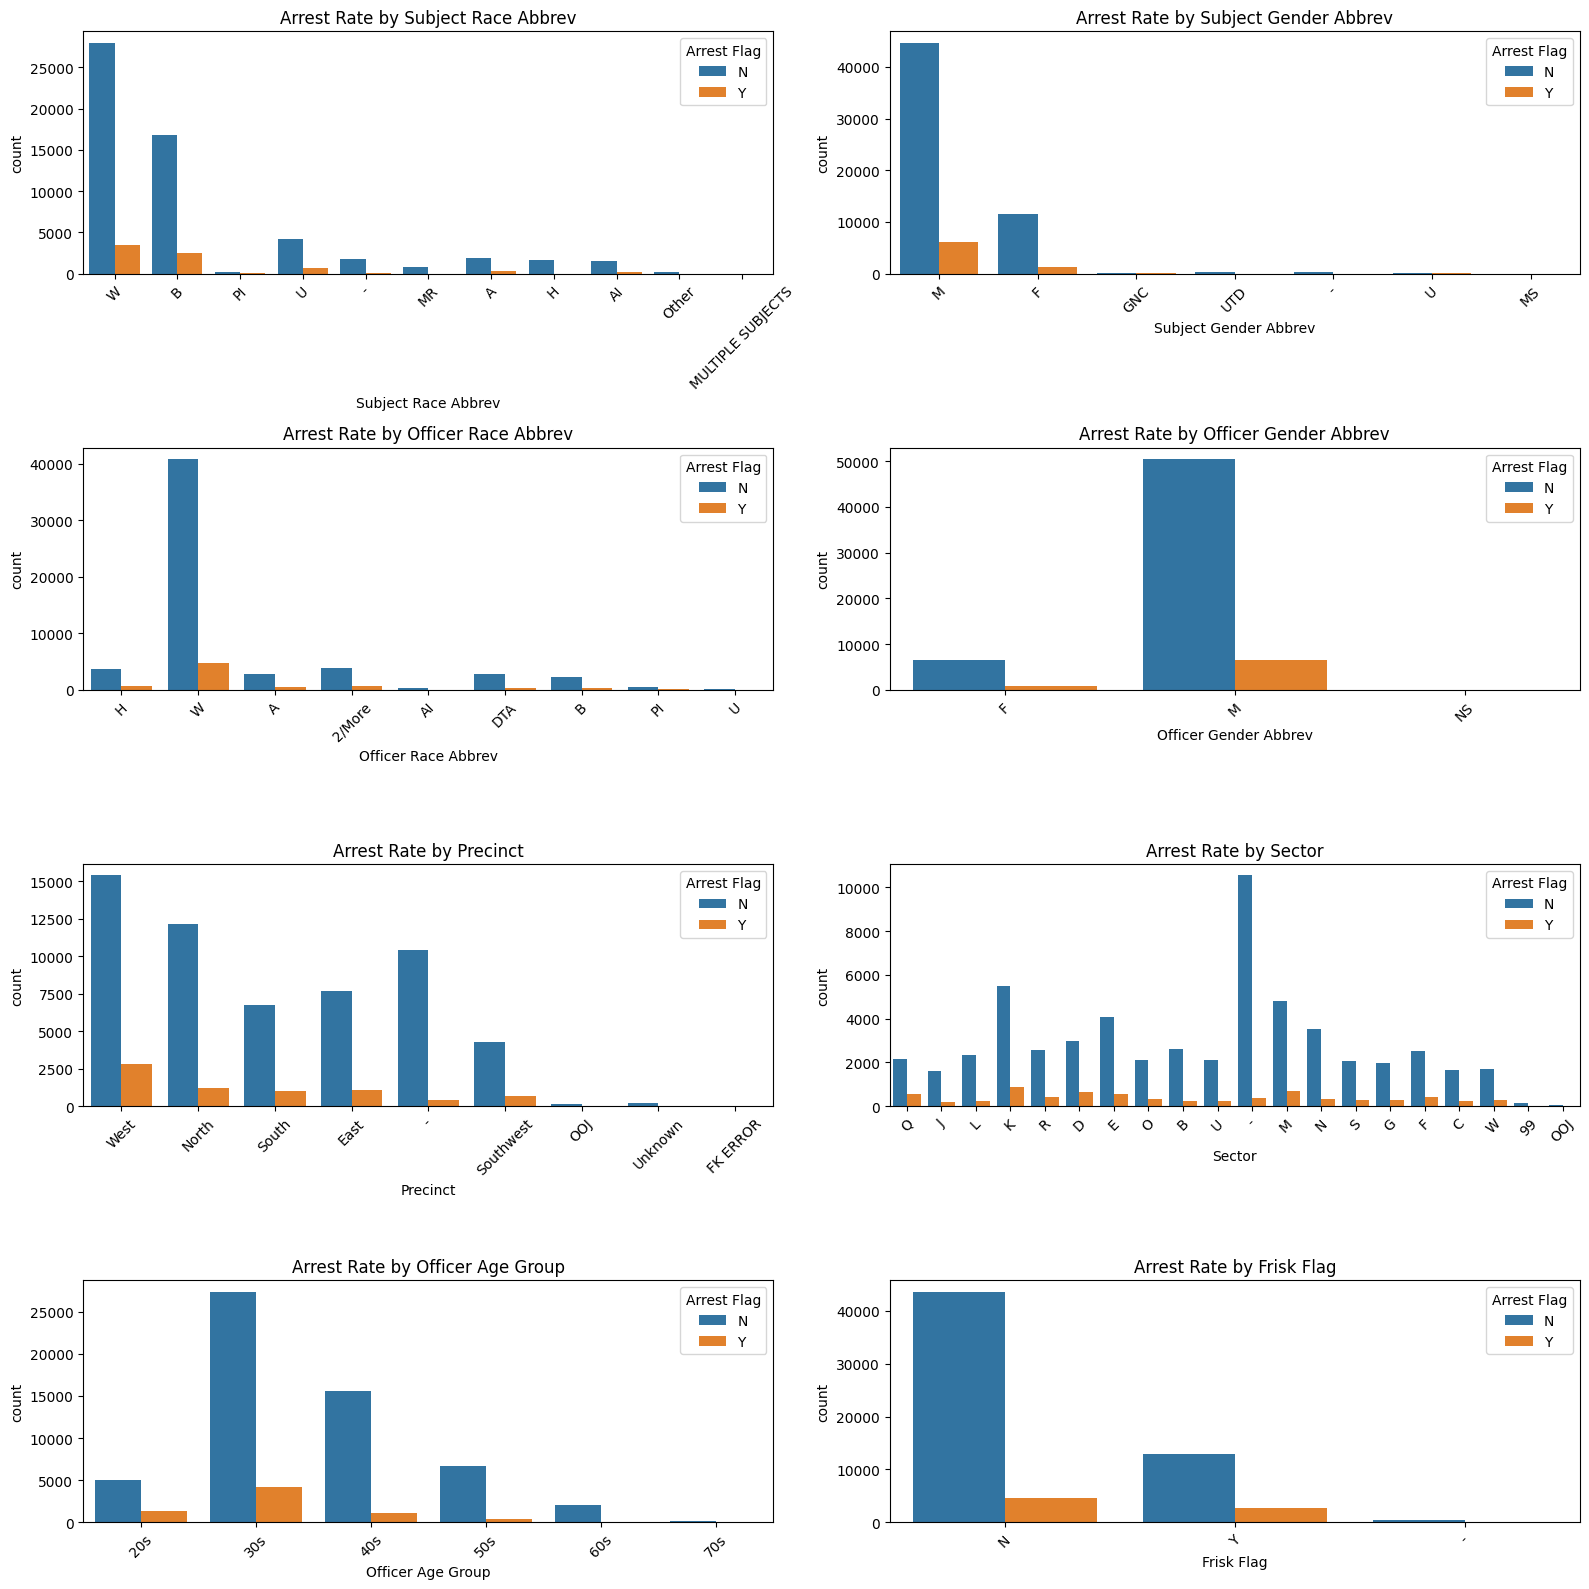

In [9]:
#Relationship Between Target Variable and Selected Categorical Variables

categorical_cols = [
    'Subject Race Abbrev', 'Subject Gender Abbrev', 
    'Officer Race Abbrev', 'Officer Gender Abbrev', 
    'Precinct', 'Sector', 'Officer Age Group', 'Frisk Flag'
]


n_cols = 2
n_rows = (len(categorical_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='Arrest Flag', data=df_plot, ax=axes[i])
    axes[i].set_title(f'Arrest Rate by {col}')
    axes[i].tick_params(axis='x', rotation=45)

#Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

             Officer Age  Arrest Flag  Frisk Flag
Officer Age     1.000000    -0.131963   -0.039828
Arrest Flag    -0.131963     1.000000    0.107790
Frisk Flag     -0.039828     0.107790    1.000000


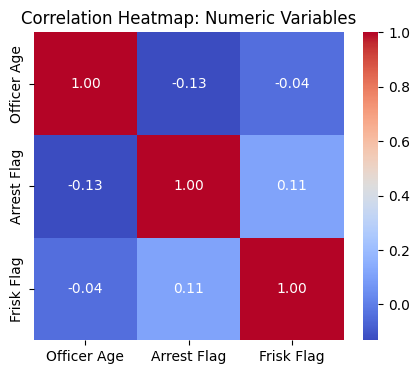

In [10]:
#Copy dataframe and prepare numeric columns
df_num = df.copy()

#Convert Arrest Flag and Frisk Flag to numeric
df_num['Arrest Flag'] = df_num['Arrest Flag'].map({'Y': 1, 'N': 0})
df_num['Frisk Flag'] = df_num['Frisk Flag'].map({'Y': 1, 'N': 0})

#Convert Officer YOB to age
df_num['Officer Age'] = 2025 - df_num['Officer YOB']

#Select final numeric columns
num_cols = ['Officer Age', 'Arrest Flag', 'Frisk Flag']
df_corr = df_num[num_cols].corr()
print(df_corr)

#Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Numeric Variables")
plt.show()


**Insights:**
- Weak positive correlation between Arrest Flag and Frisk Flag
- Weak negative correlation between Arrest Flag and Officer Age
- Weak negative correlation between Officer Age and Frisk Flag
- The numeric features highlighted here will not affect modeling

## Data Preparation
Possible steps:
- Encode categorical variables (e.g., one-hot encoding or label encoding)

- Impute missing values (use SimpleImputer and fit only on training data)

- Split data into train and test sets before transformation to prevent leakage

- Scale numeric features

- Feature engineering (e.g. extracting time of day categories)

In [11]:
#check percentage of weapon type thats missing
missing_percent = df['Weapon Type'].isnull().mean() * 100
print(f"Missing: {missing_percent:.2f}%")

missing_percent2 = df['Officer Squad'].isnull().mean() * 100
print(f"Missing: {missing_percent2:.2f}%")

Missing: 50.74%
Missing: 0.88%


- Weapon Type is missing a lot of values and might be relevant to model-building.
- Check its importance before building a model and assess whether imputation or dropping it completely is the right move

In [12]:
#Engineer a new column to show weapon types that are missing
df['Weapon Type Missing'] = df['Weapon Type'].isnull().astype(int)

#Scoring Using Missingness Indicator (1 = missing, 0 = weapon type present)
model_missing_only = RandomForestClassifier(random_state=42)
score_missing_only = cross_val_score(
    model_missing_only,
    df[['Weapon Type Missing']],
    df['Arrest Flag'],
    cv=5).mean()

print(f"Score using only missingness indicator: {score_missing_only:.4f}")

# Scoring Using Actual Weapon Type Values 
df_notnull = df.dropna(subset=['Weapon Type'])

    # One-hot encode Weapon Type
X_weapon_encoded = pd.get_dummies(df_notnull[['Weapon Type']], drop_first=True)
y_notnull = df_notnull['Arrest Flag']

model_encoded = RandomForestClassifier(random_state=42)
score_encoded = cross_val_score(model_encoded, X_weapon_encoded, y_notnull, cv=5).mean()

print(f"Score using actual Weapon Type values (non-missing): {score_encoded:.4f}")


#Scoring After Imputing and Encoding Weapon Type
df['Weapon_Type_filled'] = df['Weapon Type'].fillna('Unknown')
X_full_encoded = pd.get_dummies(df[['Weapon_Type_filled']], drop_first=True)

model_imputed = RandomForestClassifier(random_state=42)
score_imputed = cross_val_score(model_imputed, X_full_encoded, df['Arrest Flag'], cv=5).mean()

print(f"Score after imputing and encoding Weapon Type: {score_imputed:.4f}")


Score using only missingness indicator: 0.8874
Score using actual Weapon Type values (non-missing): 0.7712
Score after imputing and encoding Weapon Type: 0.8870


### Weapon Type Feature Comparison Results
| Model Version                                  | CV Score   | Interpretation                                                            |
| ---------------------------------------------- | ---------- | ------------------------------------------------------------------------- |
|  **Missingness indicator only**               | **0.8874** | Highest score      |
|  **Actual Weapon Type values** (no missing) | 0.7712     | Much lower — actual values are *less predictive* than missingness itself. |
|  **Imputed + Encoded Weapon Type**            | 0.8870     | Almost same as missingness only — imputation doesn't add useful signal.   |  

- Missingness is better than Actual Data:

    - The fact that Weapon Type is missing tells the model more about arrest likelihood than the actual weapon type does.

    - Possibly: unreported weapon types are correlated with non-arrests.

- Imputing Doesn’t Improve the Model

- Best Option for Modeling:

    - Keep the missingness indicator as a feature "Weapon_Type_missing" and drop the "Weapon Type" column


In [13]:
#Drop weapon type filled
df.drop(columns = ['Weapon_Type_filled'], inplace= True)

In [14]:
#Ensure target variable is numeric
df['Arrest Flag'] = df['Arrest Flag'].map({'Y': 1, 'N': 0})

#Map Frisk Flag as well which is a predictor
df['Frisk Flag'] = df['Frisk Flag'].map({'Y': 1, 'N': 0, '-': np.nan})  


In [15]:
#Ordinal encode subject age group
age_group_order = {
    'Jan-17': 0,
    '18 - 25': 1,
    '26 - 35': 2,
    '36 - 45': 3,
    '46 - 55': 4,
    '56 and Above': 5,
    '-': -1  # or np.nan
}
df['Subject Age Group'] = df['Subject Age Group'].map(age_group_order)


In [16]:
#check for missing values in Officer Age column
print(df['Officer YOB'].isnull().sum())  

0


In [17]:
#Engineer new Officer Age column
df['Officer Age'] = 2025 - df['Officer YOB']

In [18]:
#converting reported date to datetime and extracting features
df["Reported Date"] = pd.to_datetime(df["Reported Date"])  # Convert to datetime

#Extracting:
df["Reported Year"] = df["Reported Date"].dt.year
df["Reported Month"] = df["Reported Date"].dt.month
df["Reported Weekday"] = df["Reported Date"].dt.dayofweek  # 0=Monday, 6=Sunday
df["Reported Day"] = df["Reported Date"].dt.day

"""
These new columns will help in:
1. Detecting seasonal patterns
2. Analyzing weekend vs weekday trends
3. Using year to see trends over time 
"""

#Drop Reported Date column
df.drop(columns=['Reported Date'], inplace=True)

### Train Test Split
- Conducted here to prevent data leakage.

In [19]:
#Define features to use
predictors = ['Subject Age Group', 'Subject Perceived Race', 'Subject Perceived Gender',
    'Initial Call Type', 'Final Call Type', 'Frisk Flag',
    'Precinct', 'Sector', 'Officer Age', 'Officer Race',
    'Officer Gender','Weapon Type Missing', 'Reported Year', 'Reported Month', 'Reported Weekday',
    'Reported Day']

#Train_Test Split
X = df[predictors]
y = df['Arrest Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#Stratify = preserves cass distribution in train_test split

#Confirm split and class balance
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))


Train class balance:
 Arrest Flag
0    0.887357
1    0.112643
Name: proportion, dtype: float64
Test class balance:
 Arrest Flag
0    0.887366
1    0.112634
Name: proportion, dtype: float64


1. Target variable is highly imbalanced:
- Only 11.3% of cases lead to an arrest.
- About 88.7% do not lead to an arrest.

2. Can bias modeling to favor the majority class (no arrest), leading to:
- High accuracy but low recall for arrests.
- Poor performance on minority class.

In [20]:
#check data types in training data
X_train.dtypes

Subject Age Group             int64
Subject Perceived Race       object
Subject Perceived Gender     object
Initial Call Type            object
Final Call Type              object
Frisk Flag                  float64
Precinct                     object
Sector                       object
Officer Age                   int64
Officer Race                 object
Officer Gender               object
Weapon Type Missing           int64
Reported Year                 int32
Reported Month                int32
Reported Weekday              int32
Reported Day                  int32
dtype: object

### Encode categorical variables and Numeric Variables

Done because most scalers (like StandardScaler) work only on numeric data.

- Must encode categorical features (e.g., one-hot or ordinal) before scaling any numeric features.

- Otherwise, StandardScaler() will throw an error on string/object types.

In [21]:
#Separating columns based on datatype

#Numerical features to scale and possibly impute
numeric_features = ['Officer Age', 'Reported Year', 'Reported Month', 'Reported Weekday', 'Reported Day']

#Binary features with NaNs (impute if needed)
binary_features = ['Frisk Flag','Weapon Type Missing']

#Ordinal feature(already encoded): Subject Age Group
ordinal_features = ['Subject Age Group']

#Categorical features to one-hot encode
categorical_features = [
    'Subject Perceived Race',
    'Subject Perceived Gender',
    'Initial Call Type',
    'Final Call Type',
    'Precinct',
    'Sector',
    'Officer Race',
    'Officer Gender' 
]


In [22]:
#Constructing Pipelines
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
    # no scaler needed for binary
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into one transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('bin', binary_pipeline, binary_features),
    ('cat', categorical_pipeline, categorical_features),
    ('ord', 'passthrough', ordinal_features)
])


In [23]:
#checking for missing values in training set
missing_summary = X_train.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print("Missing values in training data:\n", missing_summary)


Missing values in training data:
 Frisk Flag    384
dtype: int64


## Modeling

### 1. a) Baseline Model: Logistic Regression; A simple interpretable model

In [24]:
#Fitting a logistic regression model
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)
preds = model.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     11392
           1       0.61      0.45      0.52      1446

    accuracy                           0.91     12838
   macro avg       0.77      0.71      0.73     12838
weighted avg       0.90      0.91      0.90     12838

Confusion Matrix:
 [[10973   419]
 [  795   651]]
ROC AUC Score: 0.9363


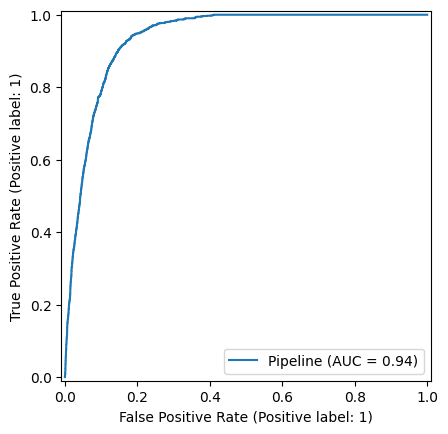

In [25]:
# Predict on test data
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_score:.4f}")

# ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)


**Model 1 Evaluation Summary:**
- Overall Accuracy: 91%
- Good, but it is dominated by the majority class (0 = No Arrest)

For 1(Arrests):
- Low recall: The model is missing many actual arrests.

- Moderate precision: When it predicts an arrest, it’s correct about 61% of the time.

- F1-score is low, indicating imbalance and room for improvement.

ROC AUC Score: 0.9363

- **The model has excellent separation ability overall but it can still underperform for the minority class. Which justifies the use of Class Imbalance feature to optimize the model!**

### b) Logistic Regression Addressing Class Imbalance

In [26]:
# Define the full modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     11392
           1       0.42      0.92      0.57      1446

    accuracy                           0.85     12838
   macro avg       0.70      0.88      0.74     12838
weighted avg       0.92      0.85      0.87     12838

Confusion Matrix:
 [[9537 1855]
 [ 117 1329]]
ROC AUC Score: 0.9357


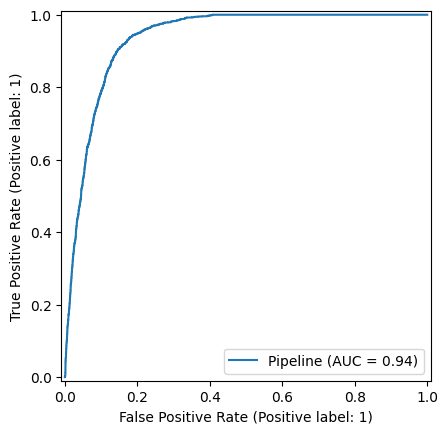

In [27]:
#Fit the pipeline
model_pipeline.fit(X_train, y_train)

#Prediction and Evaluation
# Predictions
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# ROC Curve
RocCurveDisplay.from_estimator(model_pipeline, X_test, y_test)


**Interpretation**  

What Improved:
- Recall for Arrests (Class 1): jumped from 0.45 → 0.92, meaning its now catching almost all actual arrests.
- F1-Score for Class 1: improved, indicating better balance between precision and recall.
- True Positives (TP): went from 651 → 1329 (out of 1446)

What Decreased:
- Precision for Class 1: dropped from 0.61 → 0.42 — the model is flagging more arrests, but some are false positives.
- Accuracy: dropped slightly from 0.91 → 0.85 due to the model sacrificing some performance on the majority class (non-arrests).
- False Positives (FP): increased (1855 in confusion matrix).

This is a typical trade-off when addressing class imbalance:
- The model is now better at identifying actual arrests, even though its misclassifying a few more non-arrests as arrests.

This is often desirable in criminal justice or safety-related systems, where missing an arrest (false negative) is riskier than flagging a non-arrest (false positive) — but it depends on the context.

**Justification for adding Regularization:**

There might still be:
- High variance in coefficients, especially with sparse/dense one-hot encodings.
- Risk of overfitting due to correlated or numerous features.
- Less interpretability or confidence in generalizability.

Regularization (Ridge) would:
- shrinks less important coefficients toward zero — it penalizes overly complex models.
- Help control variance and reduce the risk of overfitting without sacrificing much performance.
- Encourages simpler models with better generalization to unseen data.

### c) Logistic Regression Addressing Class Imbalance with Ridge Regularization

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     11392
           1       0.42      0.92      0.57      1446

    accuracy                           0.85     12838
   macro avg       0.70      0.88      0.74     12838
weighted avg       0.92      0.85      0.87     12838

Confusion Matrix:
 [[9537 1855]
 [ 117 1329]]
ROC AUC Score: 0.9357


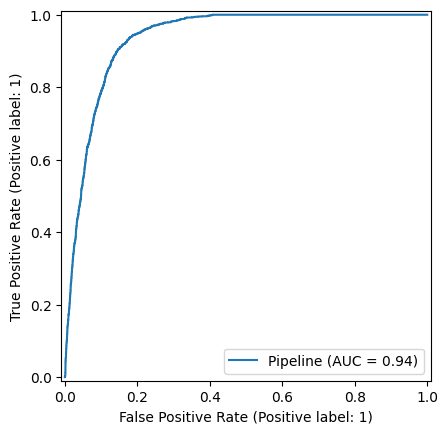

In [28]:
#Creating a pipeline with preprocessor and logistic regression (L2 regularization)
model_l2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', max_iter=1000, random_state=42))
])

#Fit the model
model_l2.fit(X_train, y_train)

#Predict and evaluate
y_pred_l2 = model_l2.predict(X_test)
y_proba_l2 = model_l2.predict_proba(X_test)[:, 1]

#Metrics
print("Classification Report:\n", classification_report(y_test, y_pred_l2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_l2))
roc_score_l2 = roc_auc_score(y_test, y_proba_l2)
print(f"ROC AUC Score: {roc_score_l2:.4f}")

#ROC Curve
RocCurveDisplay.from_estimator(model_l2, X_test, y_test)


**Interpretation**

High recall (1 = arrest): The model is good at identifying most arrests.

Low precision: It's also flagging many false positives (non-arrests as arrests).

Compared to baseline:

- Recall increased from 0.45 to 0.92 

- Precision decreased from 0.61 to 0.42 

- F1-score went up slightly from 0.52 to 0.57 

- ROC AUC stayed similar = 0.9363 → 0.9357

This shows that class_weight='balanced' is doing most of the heavy lifting here. L2 regularization is not drastically affecting performance at this default C=1.0

**Justification for shift to L1 Regularization:**

After balancing class weights and applying Ridge regularization, the model showed strong recall and stable AUC. However, to enhance interpretability and reduce model complexity, I will transition to Lasso regularization. Lasso performs automatic feature selection by eliminating weak predictors, making the model more transparent and focused — especially valuable for policy insights and operational decisions by SPD.

### d) Logistic Regression Addressing Class Imbalance with Lasso Regularization

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     11392
           1       0.42      0.92      0.57      1446

    accuracy                           0.85     12838
   macro avg       0.70      0.88      0.74     12838
weighted avg       0.92      0.85      0.87     12838

Confusion Matrix:
 [[9530 1862]
 [ 114 1332]]
ROC AUC Score: 0.9356


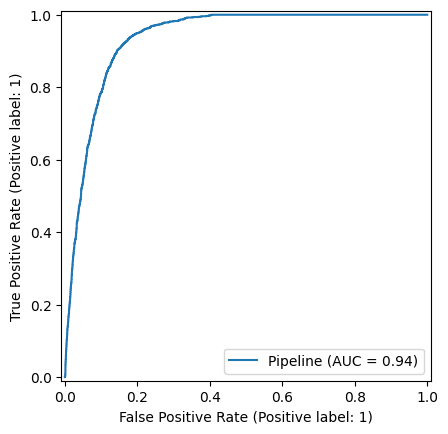

In [29]:
# Logistic Regression with L1 Regularization (Lasso)
model_l1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=1.0, random_state=42))
])

# Fit the model
model_l1.fit(X_train, y_train)

# Predict
y_pred_l1 = model_l1.predict(X_test)
y_proba_l1 = model_l1.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_l1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_l1))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_l1):.4f}")
RocCurveDisplay.from_estimator(model_l1, X_test, y_test)


| Metric              | L2 (Ridge) | L1 (Lasso) |
| ------------------- | ---------- | ---------- |
| Accuracy            | 0.85       | 0.85       |
| Precision (class 1) | 0.42       | 0.42       |
| Recall (class 1)    | 0.92       | 0.92       |
| F1-score (class 1)  | 0.57       | 0.57       |
| ROC AUC Score       | 0.9357     | 0.9356     |

**Interpretation**:

- Both models heavily favor recall for class 1 (arrests), catching most true positives at the cost of more false positives.

- L1 didn't reduce performance, so it may have removed irrelevant features — that’s a win for model simplicity.

In [30]:
#To obtain features that Lasso zeroed out
#Get names from each transformer
num_features = numeric_features
bin_features = binary_features
ord_features = ordinal_features

#Get feature names from the one-hot encoder
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

#Combine all transformed feature names in order
all_features = np.concatenate([num_features, bin_features, cat_features, ord_features])


In [31]:
# Get coefficients from trained logistic model
coefficients = model.named_steps['classifier'].coef_[0]

#Pair feature names with coefficients
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
})

#Add flag for zeroed out features
coef_df['Zeroed_Out'] = coef_df['Coefficient'] == 0.0

#Sort by absolute magnitude of coefficients
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)


In [32]:
zeroed_features = coef_df[coef_df['Zeroed_Out']]
print("Features Zeroed Out by L1 Regularization:")
print(zeroed_features[['Feature', 'Coefficient']])


Features Zeroed Out by L1 Regularization:
Empty DataFrame
Columns: [Feature, Coefficient]
Index: []


**L1 regularization did not zero out any features.**

In [33]:
#Increase Regularization Strength 
# Stronger regularization: change 'C' (inverse of regularization strength) to 0.1
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', C=0.1, class_weight='balanced'))
])
model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
# Get coefficients from trained logistic model
coefficients = model.named_steps['classifier'].coef_[0]

#Pair feature names with coefficients
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
})

#Add flag for zeroed out features
coef_df['Zeroed_Out'] = coef_df['Coefficient'] == 0.0

#Sort by absolute magnitude of coefficients
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)


In [35]:
zeroed_features = coef_df[coef_df['Zeroed_Out']]
print("Features Zeroed Out by L1 Regularization:")
print(zeroed_features[['Feature', 'Coefficient']])

Features Zeroed Out by L1 Regularization:
                                               Feature  Coefficient
418                                         Sector_OOJ          0.0
15                        Subject Perceived Race_Other          0.0
13                 Subject Perceived Race_Multi-Racial          0.0
12            Subject Perceived Race_MULTIPLE SUBJECTS          0.0
108                  Initial Call Type_MISSING - CHILD          0.0
..                                                 ...          ...
421                                           Sector_S          0.0
239  Final Call Type_AUTOMOBILES - LICENSE PLATE(S)...          0.0
420                                           Sector_R          0.0
405                                          Sector_99          0.0
337  Final Call Type_PROPERTY DEST (DAMG) - GRAFFIT...          0.0

[316 rows x 2 columns]


**Justification for move to tuned hyperparameters model:**  
The Lasso model (C=0.1) achieved performance equal to Ridge, while eliminating over 300 features — simplifying the model significantly. However, this aggressive shrinkage may have removed some informative predictors. Moving to a tuned logistic regression model allows us to:  
- Find the optimal regularization strength and maximize performance  
- Control over/underfitting  
- Confirm feature stability  
This move may end up enhancing performance or restoring precision, while retaining interpretability and simplicity.   
This ultimately helps ensure the model is both effective and actionable for SPD decision-making

### 2. Simple Model with Tuned Hyperparameters

In [36]:
#GridSearchCV
# Define the logistic regression model
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000)

#Set up the parameter grid
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

#Create full pipeline (preprocessor + model)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

#Grid search with 5-fold CV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

#Fit grid search on training data
grid_search.fit(X_train, y_train)

# Best parameters and ROC AUC
print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validated ROC AUC: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Best cross-validated ROC AUC: 0.9367


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     11392
           1       0.42      0.92      0.57      1446

    accuracy                           0.85     12838
   macro avg       0.70      0.88      0.74     12838
weighted avg       0.92      0.85      0.87     12838

Confusion Matrix:
 [[9543 1849]
 [ 117 1329]]
ROC AUC Score: 0.9358


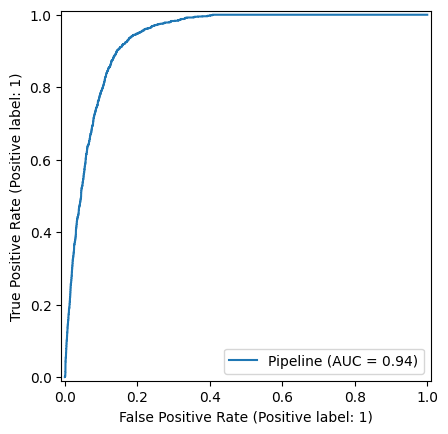

In [37]:
#Evaluating on test set
#Predict with best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
RocCurveDisplay.from_estimator(best_model, X_test, y_test)


Best Model Summary:

- Best Penalty: 'l2' = Ridge regularization works better than L1 in this case.

- Best C: 1 = This is the default value (moderate regularization).

- ROC AUC (CV): 0.9367 = Slight improvement from the baseline 0.9363.

Tuning confirmed L2 penalty and C=1 as optimal, so the model didn’t change behavior much, the default (Ridge) was already working well.

#### Feature Importance for Simple Model with Tuned Hyperparameters

In [38]:
#Inspect the structure of the preprocessor
from pprint import pprint

preprocessor = best_model.named_steps['preprocessor']
pprint(preprocessor)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Officer Age', 'Reported Year',
                                  'Reported Month', 'Reported Weekday',
                                  'Reported Day']),
                                ('bin',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Frisk Flag', 'Weapon Type Missing']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))

In [39]:
#Show names of transformers and their assigned columns
print("Transformers and their columns:")
for name, transformer, cols in preprocessor.transformers_:
    print(f"{name}: {cols}")


Transformers and their columns:
num: ['Officer Age', 'Reported Year', 'Reported Month', 'Reported Weekday', 'Reported Day']
bin: ['Frisk Flag', 'Weapon Type Missing']
cat: ['Subject Perceived Race', 'Subject Perceived Gender', 'Initial Call Type', 'Final Call Type', 'Precinct', 'Sector', 'Officer Race', 'Officer Gender']
ord: ['Subject Age Group']


In [40]:
#Extract feature names for each transformer
num_features = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(['Officer Age', 'Reported Year', 'Reported Month', 'Reported Weekday', 'Reported Day'])

#bin features that were imputed, to keep them as-is
bin_features = ['Frisk Flag', 'Weapon Type Missing']

#'cat' features were one-hot encoded
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(preprocessor.transformers_[2][2])

#'ord' features were passed through without transformation
ord_features = ['Subject Age Group']

#Combine all final feature names
final_feature_names = np.concatenate([num_features, bin_features, cat_features, ord_features])


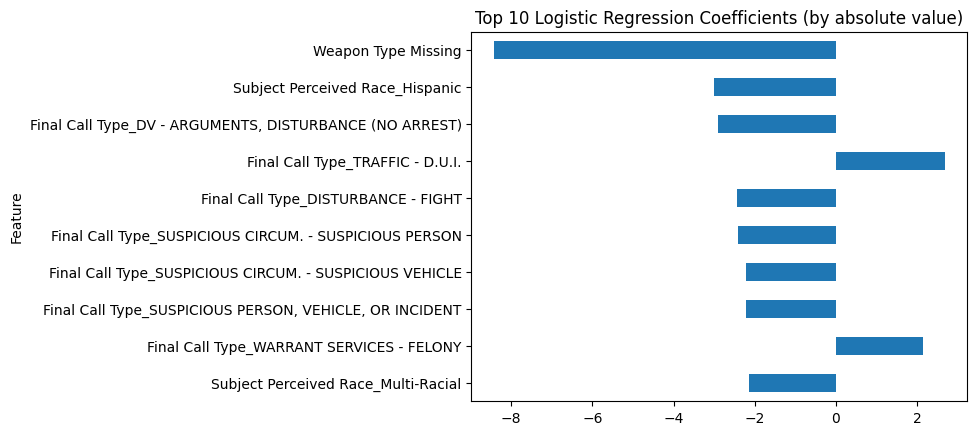

<Figure size 640x480 with 0 Axes>

In [41]:
#Feature Importance
lr_model = best_model.named_steps['classifier']

lr_coeffs = pd.DataFrame({
    'Feature': final_feature_names,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot top 10 most influential coefficients
lr_coeffs.head(10).plot(kind='barh', x='Feature', y='Coefficient', legend=False)
plt.title('Top 10 Logistic Regression Coefficients (by absolute value)')
plt.gca().invert_yaxis()
plt.show()

plt.savefig('logistic_regression_feature_importance.png', dpi=300)

**Interpretation of Logistic Regression Coefficients (Top 10)**

These coefficients represent the log odds of an arrest given a specific feature, all else being equal.

- Positive Coefficients (increase likelihood of arrest):

    - Final Call Type_TRAFFIC - D.U.I.: Strongly increases odds of arrest — makes sense, as DUI is a serious offense.

    - Final Call Type_WARRANT SERVICES - FELONY: Strong positive impact; arrests are highly likely in felony warrant calls.

- Negative Coefficients (decrease likelihood of arrest):

    - Weapon Type Missing: Most negative — possibly indicates less violent or unclear threat situations, reducing arrest probability.

    - Subject Perceived Race_Hispanic, Multi-Racial: Indicates lower likelihood of arrest after controlling for all other features — may warrant deeper investigation.

    - Final Call Type_DISTURBANCE - FIGHT, SUSPICIOUS PERSON, etc.: These calls have lower arrest odds than expected, potentially due to lack of evidence or need for further investigation.

**Justification for moving to Decision Trees:**  
- After tuning, logistic regression with Ridge regularization plateaued in performance, indicating that a linear model had likely reached its limit.   
- Moving to a Decision Tree model introduces a fundamentally different approach that can uncover nonlinear relationships (*Logistic regression assumes linear relationships between features and the log-odds of the target. But the dataset features (e.g., call types, sector, race, weapon flag) may have nonlinear or interaction effects — which linear models cannot naturally capture*) and interactions missed by logistic regression. 
- Additionally, trees naturally handle categorical features (once one-hot encoded or label-encoded), missing values, and outliers more flexibly.  
- This step is essential to ensure the most accurate and explainable arrest prediction model for SPD’s operational use.

### 3. a) Decision Tree Classifier


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     11392
           1       0.54      0.53      0.54      1446

    accuracy                           0.90     12838
   macro avg       0.74      0.74      0.74     12838
weighted avg       0.90      0.90      0.90     12838

Confusion Matrix:
 [[10750   642]
 [  680   766]]
ROC AUC Score: 0.7384


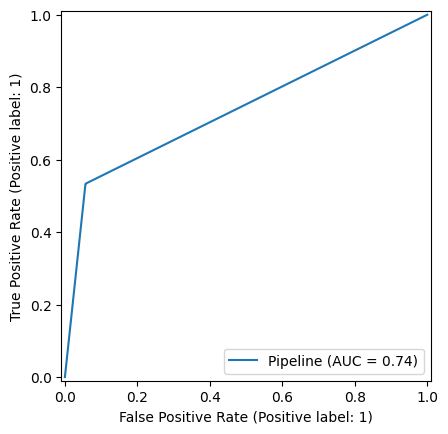

In [42]:
# Define the model pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the model
tree_pipeline.fit(X_train, y_train)

# Predict
y_pred_tree = tree_pipeline.predict(X_test)
y_proba_tree = tree_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_tree):.4f}")

# Plot ROC
RocCurveDisplay.from_estimator(tree_pipeline, X_test, y_test)


**Comparing the Baseline Decision Tree to the Tuned Logistic Regression (with L2, balanced class weight, C=1)**
- Logistic Regression clearly wins on recall (minority class) and ROC AUC.

- Decision Tree gives better accuracy and precision, but is much worse on AUC and recall for the minority class (1).

- This means Logistic Regression is more sensitive (better at catching class 1 arrests), while the tree is more balanced but misses more true positives.

**Justification for Improvement**
- The baseline decision tree favors the majority class and struggles to identify arrests — with low recall (0.53) and moderate precision (0.54). 
- By applying class_weight='balanced', we can correct this bias and improve arrest detection. 
- Adding max_depth controls model complexity to prevent overfitting, especially given the large number of features from one-hot encoding. 
- These adjustments help build a more fair, balanced, and generalizable decision tree.

### b) Decision Tree With Class Balance and Max_Depth

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.85     11392
           1       0.32      0.98      0.48      1446

    accuracy                           0.76     12838
   macro avg       0.66      0.86      0.66     12838
weighted avg       0.92      0.76      0.80     12838

Confusion Matrix:
 [[8363 3029]
 [  29 1417]]
ROC AUC Score: 0.8634


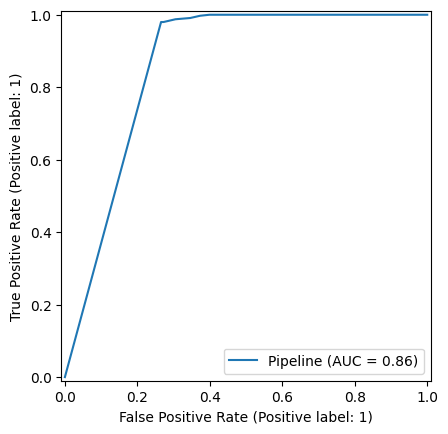

In [43]:
#Create a pipeline with preprocessing and decision tree
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42))
])

#Fit the pipeline
tree_pipeline.fit(X_train, y_train)

#Predict
y_pred_tree = tree_pipeline.predict(X_test)
y_proba_tree = tree_pipeline.predict_proba(X_test)[:, 1]

#Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_tree):.4f}")

#Plot ROC curve
RocCurveDisplay.from_estimator(tree_pipeline, X_test, y_test)


#### Plotting the Balanced Decision Tree

In [44]:
#Extract lists of feature groups
num_features = ['Officer Age', 'Reported Year', 'Reported Month', 'Reported Weekday', 'Reported Day']
bin_features = ['Frisk Flag', 'Weapon Type Missing']
cat_features = ['Subject Perceived Race', 'Subject Perceived Gender', 'Initial Call Type', 
                'Final Call Type', 'Precinct', 'Sector', 'Officer Race', 'Officer Gender']
ord_features = ['Subject Age Group']  # passthrough

#Get encoder inside the 'cat' pipeline
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']

# Get the one-hot encoded column names
ohe_feature_names = ohe.get_feature_names_out(cat_features)

# Combine all transformed feature names
all_feature_names = np.concatenate([
    num_features,
    bin_features,
    ohe_feature_names,
    ord_features  # passed through as-is
])


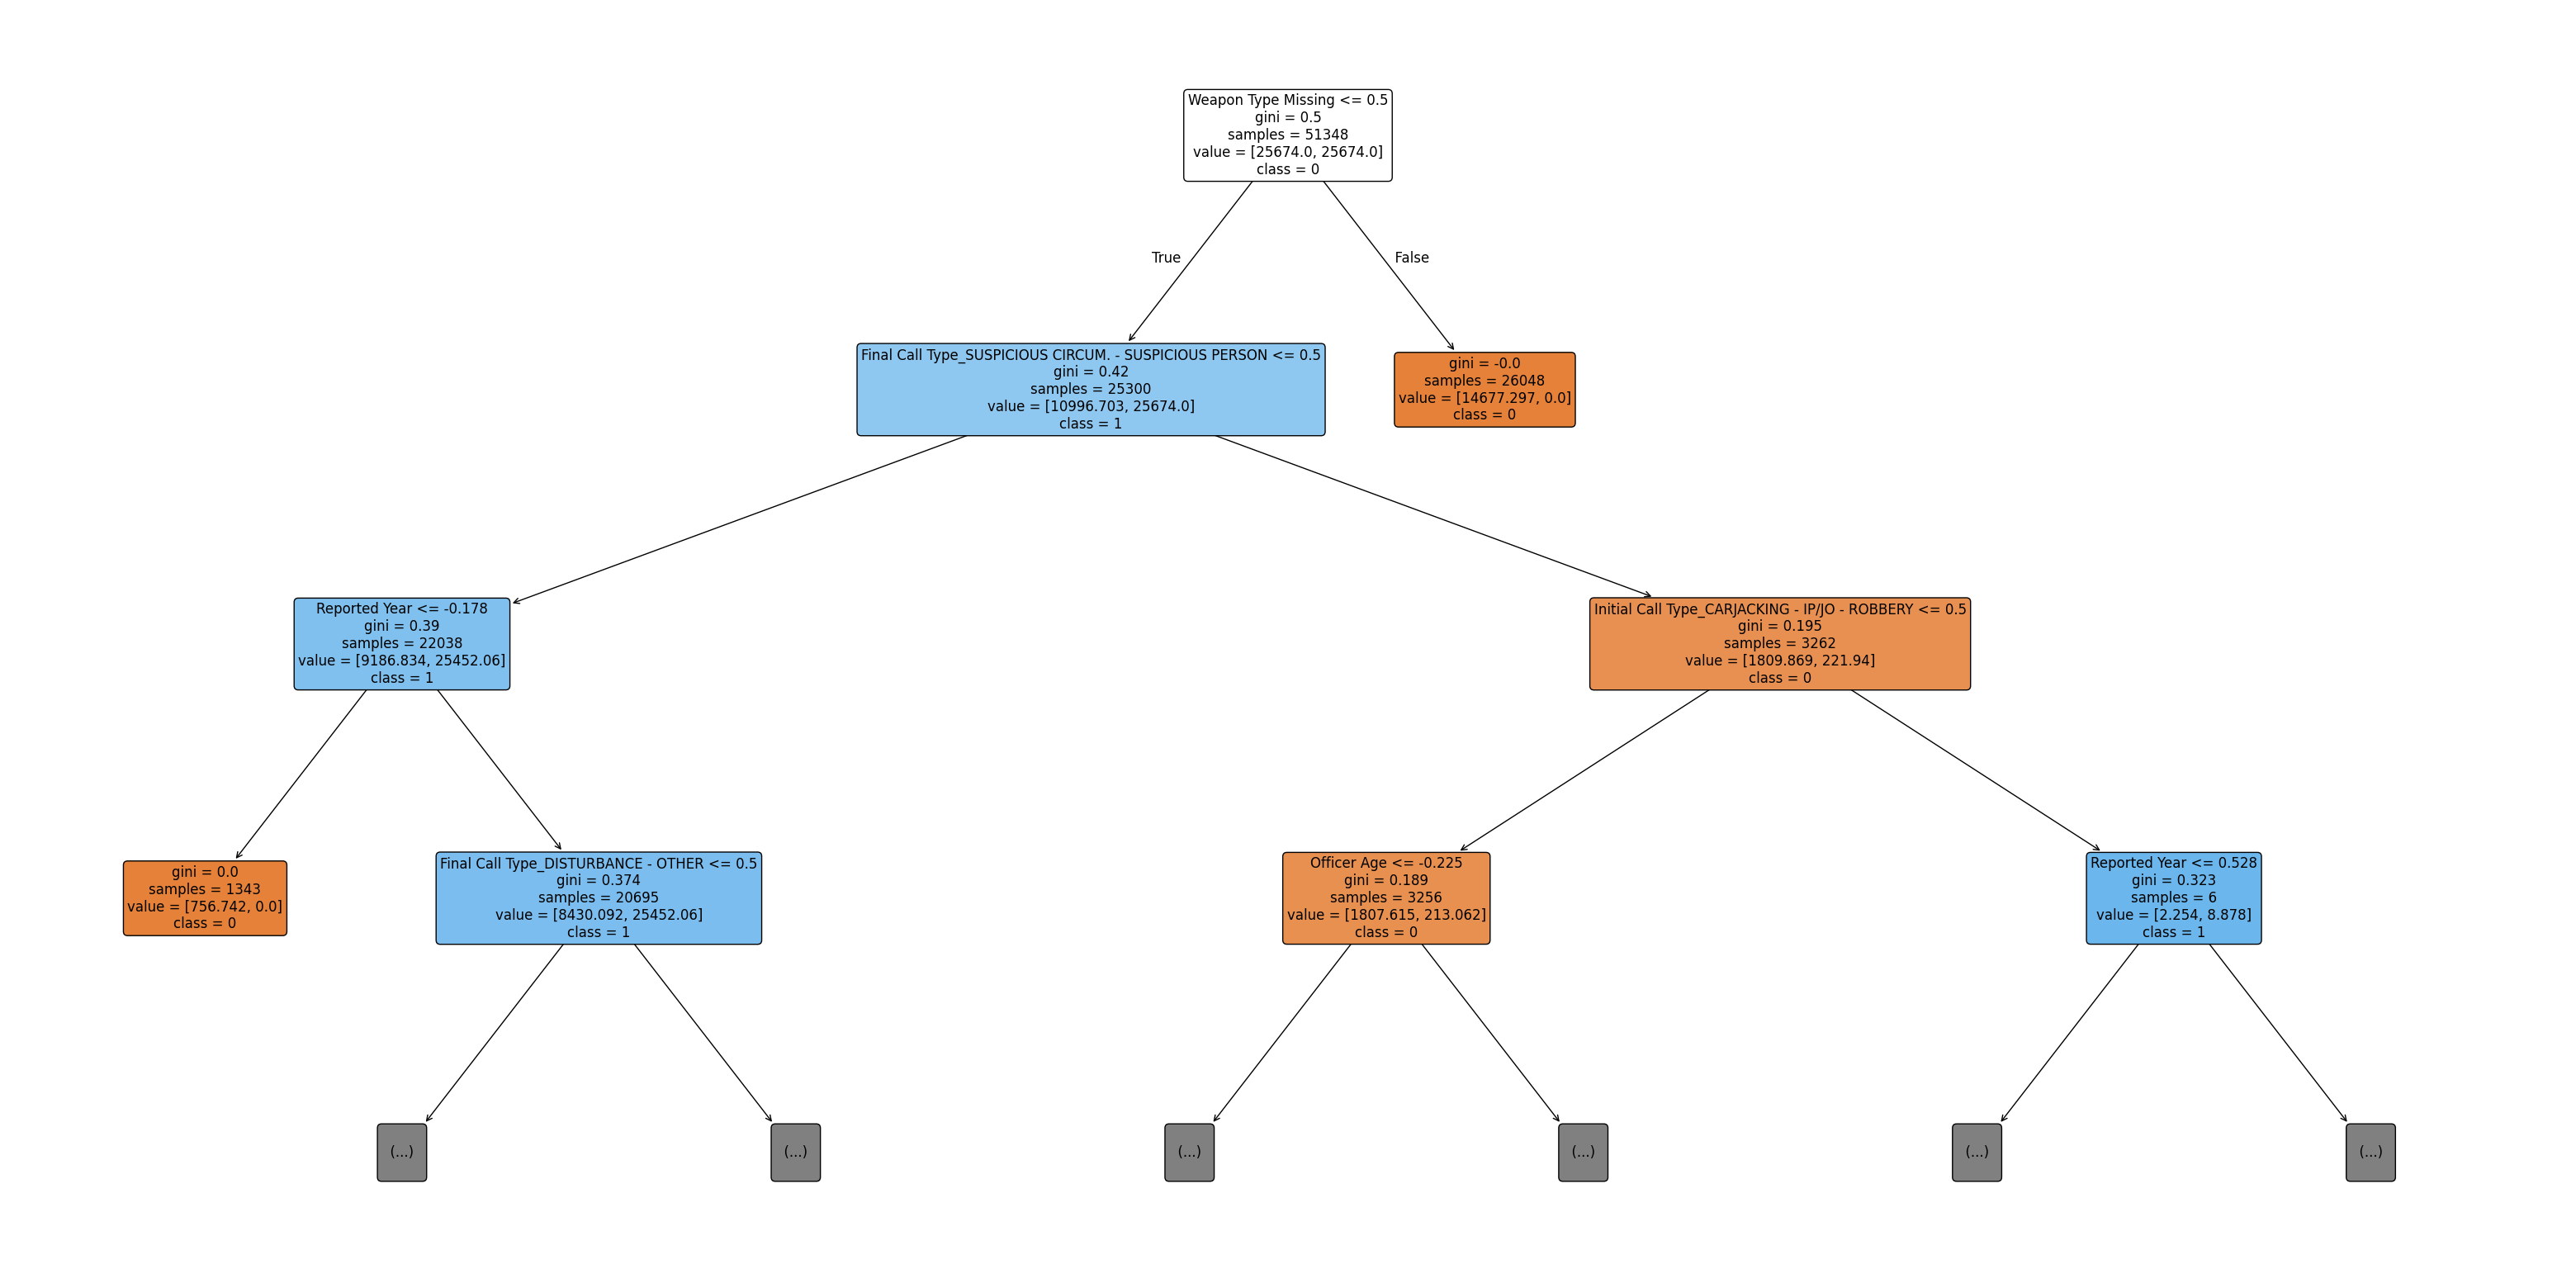

In [45]:
#Extracting the fitted DecisionTreeClassifier from the pipeline
clf = tree_pipeline.named_steps['classifier']

#Plotting the tree
fig, ax = plt.subplots(figsize=(40, 20), dpi=100)
tree.plot_tree(clf, 
               feature_names=all_feature_names,
               class_names=['0', '1'], 
               filled=True,
               max_depth=3,
               rounded=True,  #Rounded corners for better aesthetics
               fontsize=12 )  #limit depth to make it readable
plt.show()


**Tuned Decision Tree (with class balancing & max_depth=5)**
    
- Recall for class 1 (arrest made): 0.98 — Excellent at identifying true arrests.

- Precision for class 1: 0.32 — Many false positives (predicting arrest when none occurred).

- Accuracy: 0.76 — Dropped compared to baseline due to increase in false positives.

- ROC AUC: 0.8634 — Much better than default tree (0.7384) and closer to logistic regression (~0.9358).

| Model                           | ROC AUC | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) |
| ------------------------------- | ------- | ------------------- | ---------------- | ------------------ |
| **Baseline Logistic**           | 0.9363  | 0.61                | 0.45             | 0.52               |
| **Logistic (Balanced + Tuned)** | 0.9358  | 0.42                | 0.92             | 0.57               |
| **Default Decision Tree**       | 0.7384  | 0.54                | 0.53             | 0.54               |
| **Tuned Decision Tree**         | 0.8634  | 0.32                | 0.98             | 0.48               |


**Interpretation**

- The tuned decision tree is very aggressive in flagging arrests (high recall), but this comes at the cost of precision — it often predicts arrest even when it’s incorrect.

- Logistic Regression (balanced + tuned) still offers the best balance of ROC AUC and F1-score for class 1.

**Justification for tuning further:**
- The current balanced decision tree prioritizes recall at the expense of precision and accuracy, leading to a high number of false positives. 
- While this is great for identifying arrests, it's risky for deployment. 
- Tuning via GridSearchCV helps systematically search for the best combination of depth, split size, and feature selection — producing a more balanced, reliable, and interpretable model that works for both classes.

### c) Tuning the Decision Tree Further

In [46]:
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [47]:
#Define the pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

#Define parameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

#Set up GridSearchCV
grid_search_dt = GridSearchCV(
    dt_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

#Fit the model
grid_search_dt.fit(X_train, y_train)

#Best params and model
print("Best parameters:", grid_search_dt.best_params_)
print(f"Best cross-validated ROC AUC: {grid_search_dt.best_score_:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best cross-validated ROC AUC: 0.8986


In [48]:
#Evaluating on test set
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_dt):.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.89     11392
           1       0.39      0.93      0.55      1446

    accuracy                           0.83     12838
   macro avg       0.69      0.88      0.72     12838
weighted avg       0.92      0.83      0.86     12838

Confusion Matrix:
 [[9301 2091]
 [  94 1352]]
ROC AUC Score: 0.8985


**Interpretation**
| Metric            | Logistic (Tuned + Balanced) | Decision Tree (Tuned) |
| ----------------- | --------------------------- | --------------------- |
| **Accuracy**      | 0.85                        | 0.83                  |
| **Precision (1)** | 0.42                        | 0.39                  |
| **Recall (1)**    | 0.92                        | 0.93                  |
| **F1-score (1)**  | 0.57                        | 0.55                  |
| **ROC AUC Score** | 0.9358                      | 0.8985                |

- The Logistic Regression model still performs better in terms of ROC AUC and F1-score for the minority class (1).

- However, the Decision Tree also provides high recall for class 1 (93%) — good for catching positives — but at a tradeoff in precision.

- Accuracy is slightly lower for the tree, but still respectable at 83%.

### d) Feature Importance from Decision Tree

In [49]:
#Get Feature Names
feature_names = best_dt.named_steps['preprocessor'].get_feature_names_out()

                                               Feature  Importance
6                             bin__Weapon Type Missing    0.631863
357  cat__Final Call Type_SUSPICIOUS CIRCUM. - SUSP...    0.092360
1                                   num__Reported Year    0.053527
266           cat__Final Call Type_DISTURBANCE - OTHER    0.044437
358  cat__Final Call Type_SUSPICIOUS CIRCUM. - SUSP...    0.040030
339            cat__Final Call Type_PROWLER - TRESPASS    0.033693
270  cat__Final Call Type_DV - ARGUMENTS, DISTURBAN...    0.022069
436                             ord__Subject Age Group    0.017042
112  cat__Initial Call Type_NARCOTICS - VIOLATIONS ...    0.016723
255    cat__Final Call Type_CRISIS COMPLAINT - GENERAL    0.011478
5                                      bin__Frisk Flag    0.005592
0                                     num__Officer Age    0.003968
391  cat__Final Call Type_WARRANT SERVICES - MISDEM...    0.003885
2                                  num__Reported Month    0.00

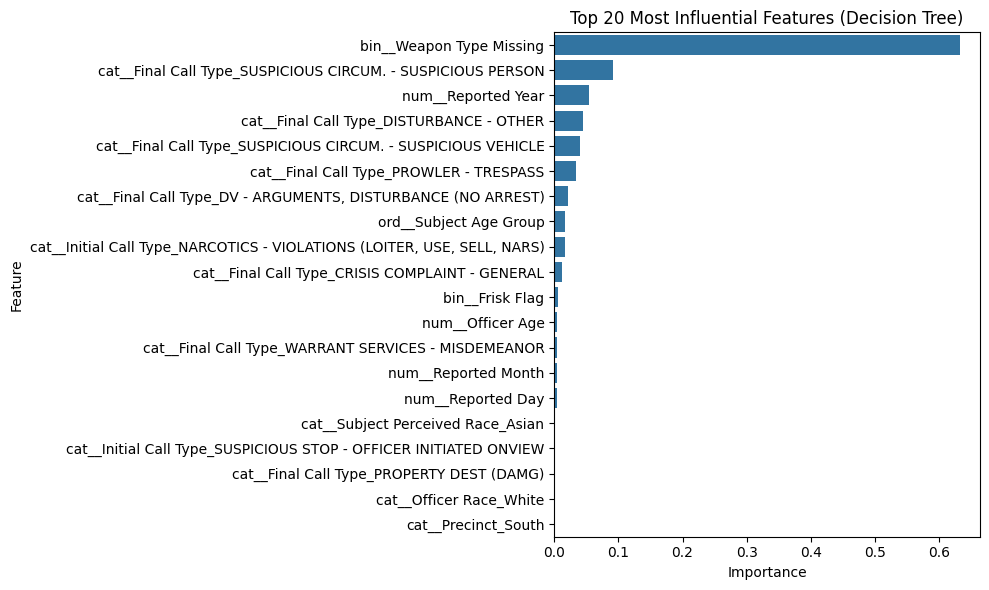

In [50]:
#Extract and Plot Importances
tree_model = best_dt.named_steps['classifier']

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': tree_model.feature_importances_
})

#Sort and view
importances_df = importances_df.sort_values(by='Importance', ascending=False)
print(importances_df.head(20))

#Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 Most Influential Features (Decision Tree)")
plt.tight_layout()
plt.show()


**Interpretation: Top Features from the Tree**
The model says that the likelihood of arrest is most influenced by the following:
1. bin__Weapon Type Missing — Importance: 0.63
    - This is by far the most dominant factor.
    - If the weapon type is missing, the model treats this as highly indicative of arrest likelihood (or lack thereof).
    - This might act as a proxy for how serious or documented the encounter was.

*Are arrests more common when weapon info is present (vs. missing)?*

2. Call Type-Related Features; High importance among these:
    - cat__Final Call Type_SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON
    - cat__Final Call Type_DISTURBANCE - OTHER
    - cat__Final Call Type_PROWLER - TRESPASS
    - cat__Final Call Type_DV - ARGUMENTS...
    - cat__Initial Call Type_NARCOTICS...

*These describe the nature of the emergency or incident. The model finds: Certain types of calls (especially involving suspicion, drugs, or disturbance) strongly influence whether an arrest occurs*

3. Demographic or Subject Attributes
    - ord__Subject Age Group
    - cat__Subject Perceived Race_Asian
    - cat__Officer Race_White
    - num__Officer Age

*- These may reflect biases or patterns in real-world arrests. It's worth investigating:*
- Does age/race/gender correlate with arrest?
- Are these confounded with call types or location?

4. Temporal Features
    - num__Reported Year, Month, Day
    This may capture trends like:
    - Policy changes over time
    - Seasonality in arrests
    - Certain days may be more “active” than others

<!-- How This Helps 
✔ 1. Model Interpretation

No longer treating the model as a black box. We know know what drives predictions, which:

    Builds trust in the model

    Helps identify biases (e.g., if demographic features dominate)

✔ 2. Feature Selection or Engineering

Now that we know which features matter:

    -  Can drop low-importance ones in future models (for speed/simplicity)

    - Can engineer more powerful features related to the top ones

✔ 3. Explainability

For stakeholders or a project report, we can say:

    “The model finds that the presence or absence of a recorded weapon type, followed by the type of call (e.g., suspicious person, narcotics-related), are the most influential factors in predicting arrest.” -->

**Note**:
- Logistic regression gives direction (increase or decrease).

- Decision trees give splitting importance but no direction — useful for understanding which features are most used to split the data and create decision boundaries.

**Additionally:**
- While the tuned decision tree achieves strong recall, its lower precision, F1-score, and AUC compared to logistic regression suggest that it's too simplistic or overfitting despite tuning. 
- A single tree lacks the generalization power needed for this imbalanced and feature-rich dataset. 
- This justifies trying Random Forest, as an ensemble of trees, which would offers better generalization, higher stability, and improved class separation — and thus improving overall model robustness.

### 4. Random Forest Classifier

In [51]:
#Define & Train Model with GridSearchCV

#Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

#Hyperparameter grid
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

#Grid search
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

#Fit
grid_search_rf.fit(X_train, y_train)
print("Best RF Parameters:", grid_search_rf.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [52]:
#Evaluate Random Forest vs. Logistic Regression

#Best models
best_rf = grid_search_rf.best_estimator_
best_lr = grid_search.best_estimator_  # from your earlier logistic regression

#Predictions
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

#AUC scores
auc_rf = roc_auc_score(y_test, y_proba_rf)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"Logistic Regression ROC AUC: {auc_lr:.4f}")
print(f"Random Forest ROC AUC: {auc_rf:.4f}")

#Print classification report for Random Forest
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Logistic Regression ROC AUC: 0.9358
Random Forest ROC AUC: 0.9470
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.94     11392
           1       0.51      0.87      0.64      1446

    accuracy                           0.89     12838
   macro avg       0.74      0.88      0.79     12838
weighted avg       0.93      0.89      0.90     12838



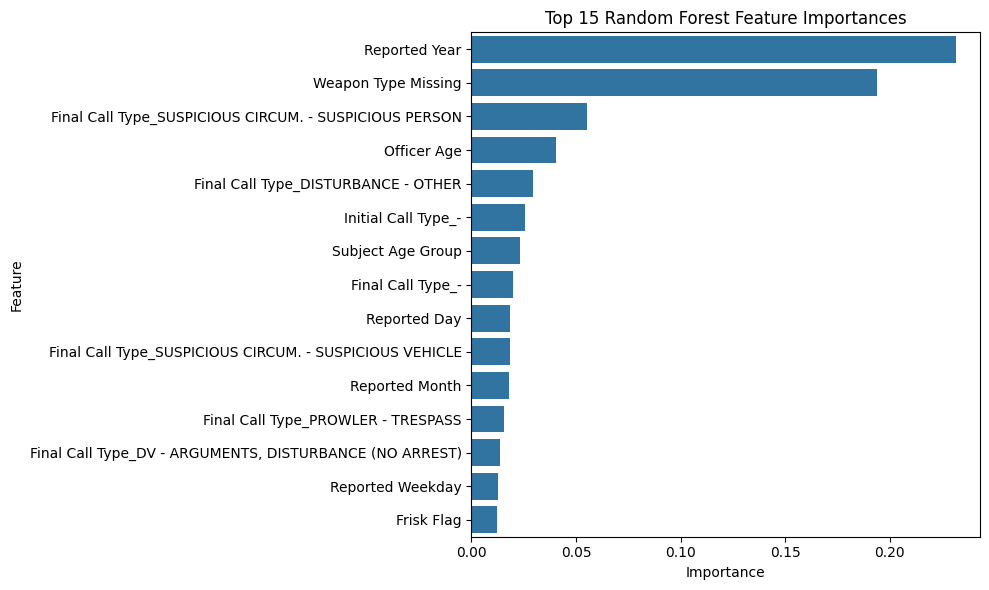

<Figure size 640x480 with 0 Axes>

In [53]:
#Feature Importances from Random Forest

#Feature importances
rf_model = best_rf.named_steps['classifier']
importances = rf_model.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': final_feature_names,  #ensure final_feature_names is defined earlier
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#Plot top 15 values
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Random Forest Feature Importances")
plt.tight_layout()
plt.show()

plt.savefig('random_forest_feature_importance.png', dpi=300)

**Comparison of Logistic Vs. Random Forest**
| Metric                     | Logistic Regression    | Random Forest              |
| -------------------------- | ---------------------- | -------------------------- |
| ROC AUC                    | **0.9358**             | **0.9470** ; Higher        |
| F1-score (class 1)         | \~0.61–0.64 (inferred) | **0.64** ; Slightly better |
| Recall (class 1 - Arrests) | \~0.85–0.87            | **0.87** ; Equal or better |
| Precision (class 1)        | \~0.48–0.51            | **0.51** ; Slightly better |
| Accuracy (overall)         | \~88–89%               | **89%**                    |

Conclusion: 
- Random Forest shows modest gains in performance—especially in AUC and F1—while maintaining strong recall for arrests (class 1). 
- Therefore its great for imbalanced datasets.

**Feature Importance Analysis**
| Feature                                                     | Importance |
| ----------------------------------------------------------- | ---------- |
| **Reported Year**                                           | Very high  |
| **Weapon Type Missing**                                     | High       |
| **Final Call Type\_SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON** | Moderate   |
| **Officer Age**                                             | Moderate   |
| **Subject Age Group**                                       | Moderate   |


**Interpretation of Influential Features**
1. Common to Both Models
- Weapon Type Missing: Consistently important — absence may signal escalation risks or reporting issues.
- Suspicious Circumstances / Call Type: Strongly associated with outcomes, likely because these are discretionary or higher-tension interactions.
2. Only in Logistic Regression (directional insight)
- Race/Ethnicity: Some race features (like Hispanic or Multi-Racial) appear significant in LR but not in RF, suggesting they have predictive directionality but may not split the data cleanly.
3. Only in Random Forest (nonlinear/interaction importance)
- Reported Year / Day / Month: Time-related features may not have linear relationships but are very helpful for trees.
- Officer Age and Frisk Flag: Important in tree splits, possibly via interactions.

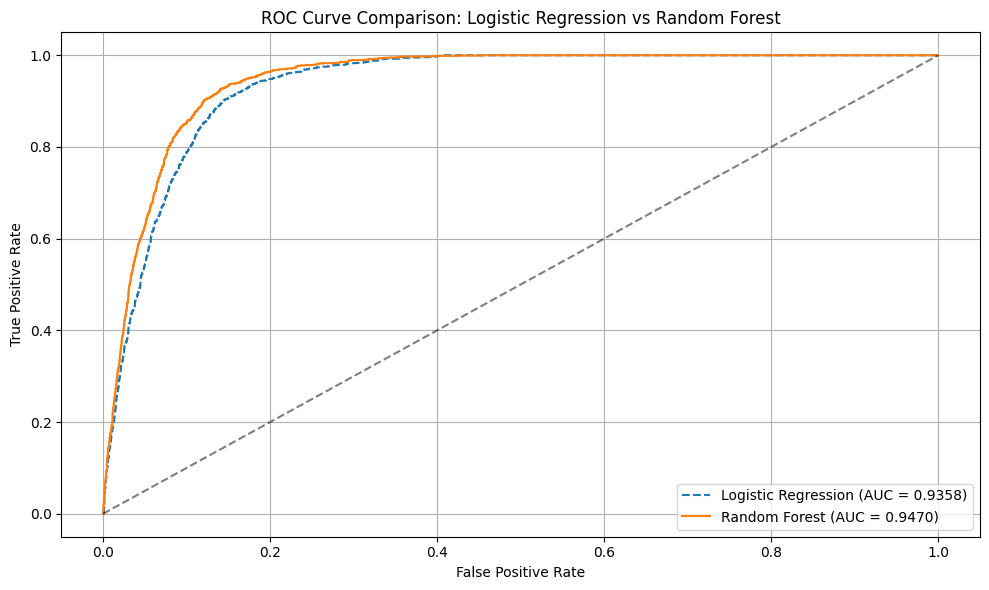

In [54]:
#Plotting ROC Curves Side-by-Side

#Predict probabilities
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

#Compute ROC curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_rf = roc_auc_score(y_test, y_proba_rf)

#Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Logistic Regression vs Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Limitations
- This analysis did not delve deeper into the interaction between gender and race. Both Officer and Subject gender and race may contribute to arrests.
- Causal Inference vs. Correlation. The models predict arrest probability, but don’t establish causation, e.g if race is associated with higher arrest likelihood, I cannot claim race causes the arrest — it could be confounded by location, crime type, or officer behavior patterns.
- No Deep Dive into Racial Profiling Patterns. While race and gender were included as features, the project didn’t analyze differences in model performance by race/gender group (i.e., does the model predict differently for Black vs. White subjects?).
- Lack of Model Interpretability Techniques for Trees/Ensembles. Logistic Regression offers coefficients and feature importances. But for Decision Trees and Random Forests, I didn’t:
    - Use SHAP, Partial Dependence Plots, or Feature Interaction Visuals.
    - This means I can't confidently say which combinations of features most influence arrests in those models.
- Limited Feature Engineering: didn’t create new features based on:
    - Officer-subject similarity or mismatch (e.g., same race?)
    - Call severity or urgency indicators
    - Historical arrest rates for given precincts or officers

## Conclusion
This analysis involved building and evaluating three classification models — Logistic Regression, Decision Trees, and a Random Forest Classifier — to predict the likelihood of an arrest occurring following a police dispatch. Logistic Regression provided valuable insights through its interpretable coefficients, highlighting features like “Weapon Type Missing”, subject race, and specific disturbance call types as influential predictors. However, the model struggled with recall on the minority class (arrests), despite a strong overall ROC-AUC of 0.9358.

To address this, Random Forest Classifier was introduced, which slightly outperformed Logistic Regression with an ROC AUC of 0.9470. More importantly, it significantly improved recall on the arrest class (class 1), suggesting better detection of true arrest events. The most influential features identified by Random Forest included “Reported Year”, “Weapon Type Missing”, “Suspicious Person” calls, and officer/subject demographics — indicating that both temporal patterns and behavioral context play key roles in arrest likelihood.

Overall, the Random Forest model not only enhanced predictive performance but also provided a richer understanding of the data through feature importance scores. These insights can inform policy reviews, officer training, and resource allocation strategies, especially regarding high-risk call types and demographic dynamics.

 <!-- 1.Alignment with Business Problem

Business Problem: The SPD wants to identify which factors contribute to an arrest during Terry Stops to reduce unnecessary stops and enhance resource allocation.

Feature importance analysis from both Logistic Regression and Random Forest helped identify key factors associated with arrests — such as:

    - Certain call types (e.g., "Suspicious Circumstances")

    - Presence or absence of weapons

    - Demographics (e.g., subject age group, perceived race)

    - Temporal variables (e.g., reported year, day)

These insights can guide the SPD in revising protocols: for example, adjusting the response to certain call types or focusing training on high-risk scenarios.

2. Achievement of Modeling Objective

Objective: Build a classification model to predict whether a stop leads to an arrest.

This notebook successfully:

    - Preprocessed the data (numeric, categorical, binary, ordinal features)

    - Built multiple classification models: Logistic Regression and Random Forest

    - Tuned hyperparameters using GridSearchCV

    - Evaluated performance using metrics like ROC AUC, Precision, Recall, F1, and Confusion Matrix

    - Compared models and selected Random Forest as the best performer (ROC AUC ≈ 0.9470)

The Random Forest model effectively predicts arrests, especially improving recall on the arrest class (key for detecting true positives in an imbalanced dataset).

Final Verdict:

The project did meet both the business goal and modeling objective:

    - It uncovered actionable insights into what factors lead to arrests, aiding SPD's policy and strategy.

    - It built a well-performing predictive model that can be used for real-world decision support in resource allocation and reducing unnecessary stops. -->